# Method 1: Navigation Data with a Sensor Parameter in Ipyleaflet
##  In this example we want to plot Thermosalinograph Temperature data on a map as a leaflet path.
##  We'll also add a marker for the current location of the ship.

## Assumes that the user knows the following:
* The common (short) name for the sensor of interest is known.
* The parameter name of interest is known.
* The time interval of interest is know.

## Workflow Steps:
1. Lookup sensor and parameter metadata to discover where to access the data of interest
2. Build an API query URL using the sensor and parameter metadata.
3. Execute the query and process the return data.
4. Plot the data on a map.

In [21]:
# Import necessary modules
import urllib.parse
import requests
import json
import os
import random
from datetime import datetime, timedelta
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd

# Supress certificate warnings.
from urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

# CONSTANT: The Base URL for our API.
api_url = "https://taani-pub-ship.taani.oregonstate.edu/api"

# DERIVATIVES: 
sensor_url = api_url + "/sensor"
parameter_url = api_url + "/parameter"

# KNOWNS
sensor_short_name = "Thermosalinograph"
parameter_short_name = "Temperature"
hour_interval = 1

In [2]:
# Step 1a: Lookup sensor metadata to discover where to access the data of interest

query_url = sensor_url + "/?sensor_name="+sensor_short_name+"&enabled=true"

# Make the query to the REST API
response = requests.get(query_url, verify=False)

# Load the response as json data
responseJSON = json.loads(response.text)

# Select the first sensor that was returned, you may have more than one to choose from.
for sensor in responseJSON:
    # Print the sensor id for each record
    sensor_id = responseJSON[0]["sensor_id"]
    print("Thermosalinograph sensor_id = " + sensor_id)

# Step 1b: Lookup parameter metadata
query_url = parameter_url+"/?sensor_id="+sensor_id+"&short_name="+parameter_short_name+"&format=json"

response = requests.get(query_url, verify=False)

# Load the response as json data
responseJSON = json.loads(response.text)
#print(responseJSON)

# Create variables to store table and field information
data_table = responseJSON[0]['binned_default_table'][:-8]+"_map"
data_field = responseJSON[0]['binned_default_fieldname']
data_units = responseJSON[0]['units_abbrev']

print("Thermosalinograph data is stored in table: " + data_table)
print("Thermosalinograph temperature data is stored in field: " + data_field)

Thermosalinograph sensor_id = seatsg450712
Thermosalinograph data is stored in table: binned_default_flow_map
Thermosalinograph temperature data is stored in field: parameter_32


In [80]:
#Step 2: Build an API Query URL with the metadata above.

query_url = "https://taani-pub-ship.taani.oregonstate.edu/api/"+data_table

# Set the start date and time using the ISO8601 format, data stored in UTC
end_date = datetime.now()
start_date = end_date - timedelta(hours=hour_interval, minutes=0, seconds=0)

# % encode the times
end_time=urllib.parse.quote(str(end_date), safe='')
start_time=urllib.parse.quote(str(start_date), safe='')
print(start_time)
print(end_time)

# Modify to include a temporal range
query_url = query_url+'/?date_after='+start_time+'&date_before='+end_time+'&format=json'

print()
print(query_url)

2024-11-19%2014%3A07%3A57.321694
2024-11-19%2015%3A07%3A57.321694

https://taani-pub-ship.taani.oregonstate.edu/api/binned_default_flow_map/?date_after=2024-11-19%2014%3A07%3A57.321694&date_before=2024-11-19%2015%3A07%3A57.321694&format=json


In [88]:
#Step 3: Run the query and process the response
response = requests.get(query_url, verify=False)

# Load the response as json data
responseJSON = json.loads(response.text)

# print(len(responseJSON))
#print(json.dumps(responseJSON, indent=4, sort_keys=True))

# Create a pandas dataframe from the data
gdf = gpd.GeoDataFrame.from_features(responseJSON['features'])
print(gdf)

                       geometry                  time   latitude   longitude  \
0   POINT (-146.14467 56.65653)  2024-11-19T15:07:00Z  56.656526 -146.144666   
1   POINT (-146.14925 56.65793)  2024-11-19T15:06:00Z  56.657935 -146.149252   
2   POINT (-146.15376 56.65937)  2024-11-19T15:05:00Z  56.659372 -146.153763   
3   POINT (-146.15834 56.66073)  2024-11-19T15:04:00Z  56.660731 -146.158338   
4   POINT (-146.16283 56.66214)  2024-11-19T15:03:00Z  56.662137 -146.162833   
5   POINT (-146.16736 56.66358)  2024-11-19T15:02:00Z  56.663582 -146.167359   
6     POINT (-146.17196 56.665)  2024-11-19T15:01:00Z  56.665004 -146.171960   
7   POINT (-146.17657 56.66637)  2024-11-19T15:00:00Z  56.666367 -146.176572   
8   POINT (-146.18105 56.66775)  2024-11-19T14:59:00Z  56.667749 -146.181047   
9   POINT (-146.18562 56.66911)  2024-11-19T14:58:00Z  56.669109 -146.185619   
10  POINT (-146.19009 56.67049)  2024-11-19T14:57:00Z  56.670492 -146.190094   
11  POINT (-146.19453 56.67188)  2024-11

<Axes: >

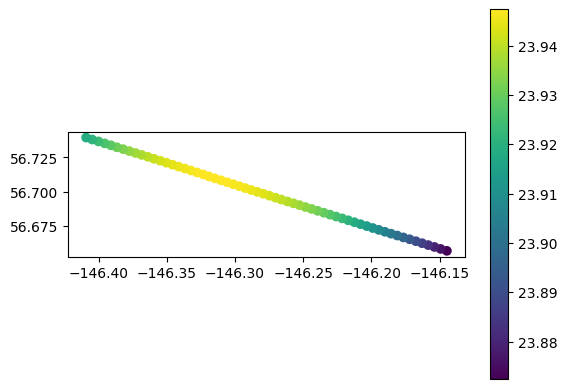

In [89]:
# Step 4.  Clean up the dataframe:

# Purge unneeded columns,
for column in gdf:
    if gdf[column].name == 'geometry': 
        pass
    elif gdf[column].name == 'parameter_32':
        pass
    else:
        del gdf[str(column)]

gdf = gpd.GeoDataFrame(gdf, columns=['geometry', 'parameter_32'])
gdf = gpd.GeoDataFrame( pd.concat([gdf.drop(['parameter_32'], axis=1), gdf['parameter_32'].apply(pd.Series)], axis=1))

# Purge unneeded columns,
for column in gdf:
    if gdf[column].name == 'geometry': 
        pass
    elif gdf[column].name == 'a':
        pass
    else:
        del gdf[str(column)]

def foo(bar):
    return bar[0]

gdf['temperature'] = gdf.apply(lambda row : foo(row.a), axis=1)

# Purge unneeded columns,
for column in gdf:
    if gdf[column].name == 'geometry': 
        pass
    elif gdf[column].name == 'temperature':
        pass
    else:
        del gdf[str(column)]

gdf
gdf.plot(column='temperature', legend=True)